In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
import os
import uuid
import random
import cv2
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [ ]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
!tar -xf lfw.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/anchor/c51f0366-4f3e-11ef-b54e-581cf894a560.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))

        data.append(img)

    return data

In [ ]:
img_path = os.path.join(ANC_PATH, 'c51f0366-4f3e-11ef-b54e-581cf894a560.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'data/anchor/d57332e5-4f3e-11ef-87ca-581cf894a560.jpg'


In [ ]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
samples = data.as_numpy_iterator()
example = samples.next()
res = preprocess_twin(*example)

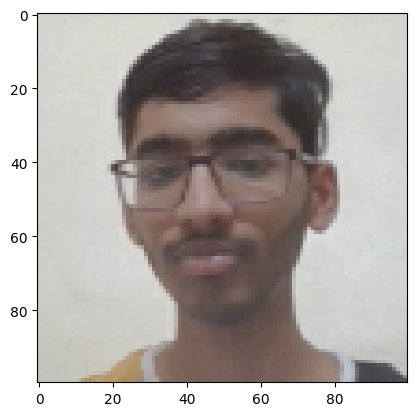

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
def make_siamese_model():

    input_image = Input(name='input_img', shape=(100,100,3))

    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
y

array([0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [ ]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 19s 307ms/step
0.08758077 0.6666667 1.0

 Epoch 2/50
27/27 [==============================] - 7s 249ms/step
0.13585004 0.9810427 0.9951923

 Epoch 3/50
27/27 [==============================] - 7s 256ms/step
0.0018823366 0.9952153 1.0

 Epoch 4/50
27/27 [==============================] - 6s 239ms/step
8.278903e-05 0.9951923 0.9951923

 Epoch 5/50
27/27 [==============================] - 8s 292ms/step
0.048750844 0.9953704 1.0

 Epoch 6/50
27/27 [==============================] - 7s 242ms/step
0.00039843164 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 7s 270ms/step
1.0430815e-07 1.0 0.9953052

 Epoch 8/50
27/27 [==============================] - 7s 270ms/step
0.0003572422 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 7s 271ms/step
1.4901165e-07 1.0 1.

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 24ms/step


In [ ]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1]

In [ ]:
y_true

array([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [ ]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [ ]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 26ms/step
1.0 0.9886364


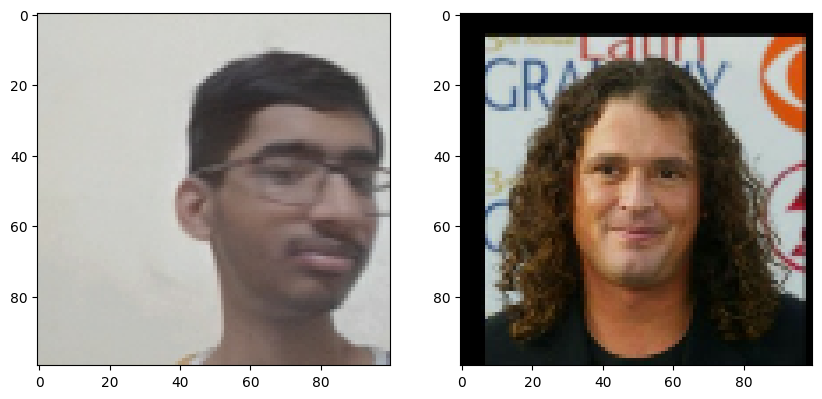

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [ ]:
siamese_model.save('siamesemodelv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 125ms/step


array([[7.5885919e-07],
       [9.9999654e-01],
       [9.6341062e-01],
       [9.9441224e-01]], dtype=float32)

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
import shutil

def copy_random_images(source_folder, destination_folder, num_images=50):
    image_files = os.listdir(source_folder)
    selected_images = random.sample(image_files, num_images)
    for image in selected_images:
        src_path = os.path.join(source_folder, image)
        dst_path = os.path.join(destination_folder, image)
        shutil.copy(src_path, dst_path)

source_folder = '/content/data/positive'
destination_folder = '/content/application_data/verification_images'
copy_random_images(source_folder, destination_folder, num_images=50)

In [ ]:
input_folder='/content/application_data/input_image'
copy_random_images(source_folder, input_folder, num_images=1)

In [ ]:
!mv /content/application_data/input_image/1d5294f4-4f53-11ef-88a0-0242ac1c000c.jpg /content/application_data/input_image/image.jpg

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

['107b3088-4f53-11ef-88a0-0242ac1c000c.jpg',
 '0c10c102-4f53-11ef-88a0-0242ac1c000c.jpg',
 '25f2eff0-4f53-11ef-88a0-0242ac1c000c.jpg',
 '160c3790-4f53-11ef-88a0-0242ac1c000c.jpg',
 '10250ca8-4f53-11ef-88a0-0242ac1c000c.jpg',
 '24fc6f72-4f53-11ef-88a0-0242ac1c000c.jpg',
 '1ad07f98-4f53-11ef-88a0-0242ac1c000c.jpg',
 'f2c8d996-4f3e-11ef-8011-581cf894a560.jpg',
 '144a5f86-4f53-11ef-88a0-0242ac1c000c.jpg',
 '2347be5c-4f53-11ef-88a0-0242ac1c000c.jpg',
 '1629c95e-4f53-11ef-88a0-0242ac1c000c.jpg',
 'f2a9dd8c-4f3e-11ef-9c48-581cf894a560.jpg',
 '25be6280-4f53-11ef-88a0-0242ac1c000c.jpg',
 '21316a00-4f53-11ef-88a0-0242ac1c000c.jpg',
 '1589d458-4f53-11ef-88a0-0242ac1c000c.jpg',
 '1cfe6c62-4f53-11ef-88a0-0242ac1c000c.jpg',
 '2522a55c-4f53-11ef-88a0-0242ac1c000c.jpg',
 '17289c90-4f53-11ef-88a0-0242ac1c000c.jpg',
 '16e8c73c-4f53-11ef-88a0-0242ac1c000c.jpg',
 '125f70bc-4f53-11ef-88a0-0242ac1c000c.jpg',
 '141a444a-4f53-11ef-88a0-0242ac1c000c.jpg',
 '05fea2cf-4f3f-11ef-9cbc-581cf894a560.jpg',
 '09ce27f4

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
!npm install -g localtunnel


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10

#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
def get_new_test_image():
  !rm -rf /content/application_data/input_image/*
  # folder=random.choice([NEG_PATH])
  folder=random.choice([NEG_PATH,ANC_PATH])
  copy_random_images(folder, input_folder, num_images=1)
  directory = '/content/application_data/input_image'

  files = os.listdir(directory)

  if files:
      current_filename = files[0]

      new_filename = 'image.jpg'

      current_file_path = os.path.join(directory, current_filename)
      new_file_path = os.path.join(directory, new_filename)

      os.rename(current_file_path, new_file_path)


In [ ]:
import matplotlib.image as mpimg


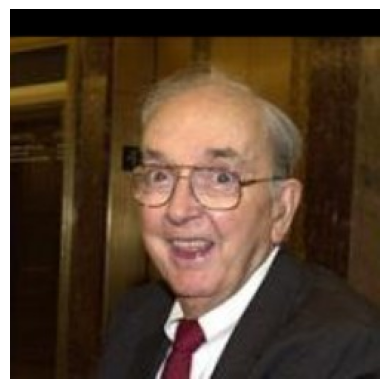

1/1 [==============================] - 0s 28ms/step
False


[array([[0.00145229]], dtype=float32),
 array([[0.41951555]], dtype=float32),
 array([[0.04049874]], dtype=float32),
 array([[0.46592894]], dtype=float32),
 array([[0.4959743]], dtype=float32),
 array([[0.5133801]], dtype=float32),
 array([[0.00016598]], dtype=float32),
 array([[2.7723376e-05]], dtype=float32),
 array([[0.83891046]], dtype=float32),
 array([[0.02980469]], dtype=float32),
 array([[0.7303025]], dtype=float32),
 array([[2.8887873e-05]], dtype=float32),
 array([[0.51572645]], dtype=float32),
 array([[0.7903612]], dtype=float32),
 array([[0.15383895]], dtype=float32),
 array([[0.49066323]], dtype=float32),
 array([[0.6982452]], dtype=float32),
 array([[0.02455912]], dtype=float32),
 array([[0.548106]], dtype=float32),
 array([[0.01221808]], dtype=float32),
 array([[0.8014772]], dtype=float32),
 array([[1.3324611e-05]], dtype=float32),
 array([[0.43335155]], dtype=float32),
 array([[0.0837858]], dtype=float32),
 array([[0.8009337]], dtype=float32),
 array([[0.6820896]], dtyp

In [ ]:
get_new_test_image()
# from PIL import Image
# image = Image.open('/content/application_data/input_image/image.jpg')
image=mpimg.imread('/content/application_data/input_image/image.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()
results, verified = verify(siamese_model, 0.5, 0.5)
print(verified)
np.sum(np.squeeze(results) > 0.9)
results


In [ ]:
url = 'https://clear-hounds-look.loca.lt/'
import requests
from IPython.display import display, Image

def get_video_frame(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        bytes = bytes()
        for chunk in response.iter_content(chunk_size=1024):
            bytes += chunk
            a = bytes.find(b'\xff\xd8')
            b = bytes.find(b'\xff\xd9')
            if a != -1 and b != -1:
                jpg = bytes[a:b + 2]
                bytes = bytes[b + 2:]
                frame = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
                return frame
    else:
        print("Received unexpected status code {}".format(response.status_code))
    return None

# Display the video frame
frame = get_video_frame(url)
if frame is not None:
    _, img_encoded = cv2.imencode('.jpg', frame)
    display(Image(data=img_encoded.tobytes()))
else:
    print("Failed to capture video frame.")

Received unexpected status code 404
Failed to capture video frame.


In [ ]:
np.sum(np.squeeze(results) > 0.9)

36

In [ ]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a